# Settings

In [3]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '../data')
OUTPUT_DIR = os.path.join(BASE_DIR, '../output')

In [17]:
model_name = 'klue/bert-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7,).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name)

data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
dataset_train, dataset_valid = train_test_split(data, test_size=0.3, stratify=data['target'],random_state=SEED)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initial

In [18]:
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        labels = data['target']
        self.inputs = []
        self.labels = []
        
        for text, label in zip(input_texts, labels):
            tokenized_input = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),  
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }
    
    def __len__(self):
        return len(self.labels)

# Clustering

In [19]:
import matplotlib.pyplot as plt
#% matplotlib inline
from transformers import AutoTokenizer, AutoModel

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7, output_hidden_states=True).to(DEVICE)
data_all = BERTDataset(data, tokenizer)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initial

In [21]:
# Test
inputs = tokenizer(data.iloc[5]['text'],return_tensors='pt').to(DEVICE)
model(inputs['input_ids'])[1][-1].squeeze()[0] #[0] #[12]

tensor([-6.9511e-01, -1.1095e+00, -5.4556e-01,  1.1734e+00,  1.4120e+00,
        -2.9538e-01,  4.3914e-01,  3.8651e-01, -2.7366e-02,  1.0291e-01,
        -1.2824e+00,  9.4771e-02, -1.3937e+00, -7.3978e-01,  4.0119e-01,
        -4.2127e-02,  1.2298e-02,  2.8473e+00,  7.4831e-01,  3.1328e-01,
         1.4097e-02, -6.5965e-01, -8.3498e-01,  9.6602e-01, -8.3845e-01,
         4.6325e-02, -6.0214e-02, -4.7711e-01, -5.9009e-01,  3.3622e-01,
        -9.2756e-01,  1.1928e+00, -5.1118e-01, -2.5462e-01, -5.8433e-01,
        -7.3886e-01, -1.2452e+00,  5.0794e-01, -1.4932e+00, -5.4203e-01,
        -5.3894e-01,  6.9677e-02,  7.7910e-01,  2.0197e-01, -1.8133e+00,
        -1.4037e-01,  3.7309e-01,  2.3182e-01,  1.0237e+00, -5.3056e-01,
        -1.3588e+00,  4.2215e-01, -9.8248e-01,  3.5378e-02, -1.1345e-02,
        -1.4934e+00,  1.9251e-01, -7.3314e-01, -1.5629e-01, -1.7058e-01,
         7.2414e-01, -3.5169e-03,  5.6137e-01,  3.7335e-01, -2.3860e-02,
         1.5765e-01, -3.6123e-01, -1.2952e-01,  1.2

In [22]:
model.eval()
preds = []
embedding = []
for idx, sample in tqdm(data.iterrows()):
    inputs = tokenizer(sample['text'], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        embedding.append(model(inputs['input_ids'])[1][-1].squeeze()[0].cpu())

7000it [01:11, 98.22it/s] 


In [23]:
df_embedding = pd.DataFrame(embedding)
df_embedding['label'] = data['target']

In [25]:
df = df_embedding.iloc[:,:-1].applymap(lambda x: x.item())
df['label'] = [int(x) for x in df_embedding['label']]

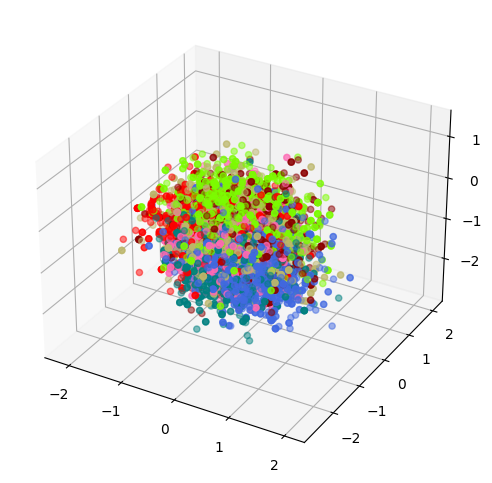

In [26]:
from utils import *
plot_scatter3D(df)

# PCA

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 표준화 시켜줌
df_scaled = StandardScaler().fit_transform(df.iloc[:,:-1])

# 주성분 분석 ! 
pca = PCA(n_components=2) # n_components 몇개의 피쳐로 데이터 차원 줄일건지 

# fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

# PCA 환된 데이터의 컬럼명을 각각 pca_component_1, pca_component_2로 명명
pca_columns=['pca_component_1','pca_component_2']
df_pca = pd.DataFrame(df_pca,columns=pca_columns)
#df_pca['target']=df_embedding_0.target

# 주성분 분석 이후 평균/표준편차 확인 
display(df_pca.describe())

,pca_component_1,pca_component_2
count,7.000000e+03,7.000000e+03
mean,-2.436147e-17,-1.624098e-17
std,7.207693e+00,6.117434e+00
min,-1.349138e+01,-1.377758e+01
25%,-5.563982e+00,-4.770714e+00
50%,-1.617169e+00,-4.884627e-01
75%,4.551800e+00,4.708044e+00
max,2.103821e+01,1.631474e+01


In [41]:
df_pca['label'] = data['target']

In [ ]:
import matplotlib.pyplot as plt

# 각 레이블별로 Isolation Forest 모델 생성 및 이상치 식별
outlier_indices_by_label = dict()
for label in np.unique(data.target.unique()):
    # 해당 레이블에 해당하는 데이터만 추출
    X_label = df_embedding[df_embedding['label'] == label].iloc[:,:-1]

    # Isolation Forest 모델 생성
    clf = IsolationForest(random_state=42)

    # 모델 학습
    clf.fit(X_label)

    # 이상치 여부 예측 (-1은 이상치를 나타냄)
    y_pred_label = clf.predict(X_label)

    # 이상치의 인덱스 가져오기
    outlier_indices_label = np.where(y_pred_label == -1)[0]
    outlier_indices_by_label[label] = outlier_indices_label
    
    # 결과 출력
    print(f"레이블 {label}의 이상치 인덱스:", outlier_indices_label)

    # 시각화: 특성 데이터의 산점도
    plt.figure(figsize=(8, 6))
    plt.scatter(X_label.iloc[:, 0], X_label.iloc[:, 1], c=y_pred_label, cmap='viridis')
    plt.title(f"Isolation Forest 이상치 식별 - 레이블 {label}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label='Outlier Predictions')
    plt.show()

# T-sne

[-36.2333   24.42883]


/tmp/ipykernel_8460/4055290467.py:14: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=data.target, legend='full', palette=palette)


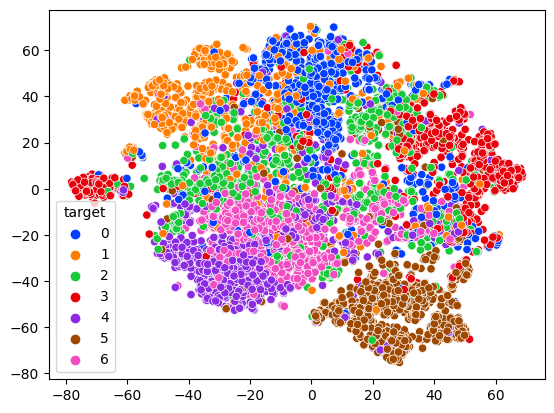

In [97]:
import seaborn as sns
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)
# data를 가지고 TSNE 모델을 훈련(적용) 합니다.
X_embedded = model.fit_transform(df.iloc[:,:-1])
# 훈련된(차원 축소된) 데이터의 첫번째 값을 출력해 봅니다. 
print(X_embedded[0])
# [65.49378 -7.3817754]

# 차원 축소된 데이터를 그래프로 만들어서 화면에 출력해 봅니다.
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=data.target, legend='full', palette=palette)
plt.show()

In [ ]:
# 정치:0
# 경제:1
# 사회:2
# 생활/문화:3
# IT/과학:4
# 세계:5

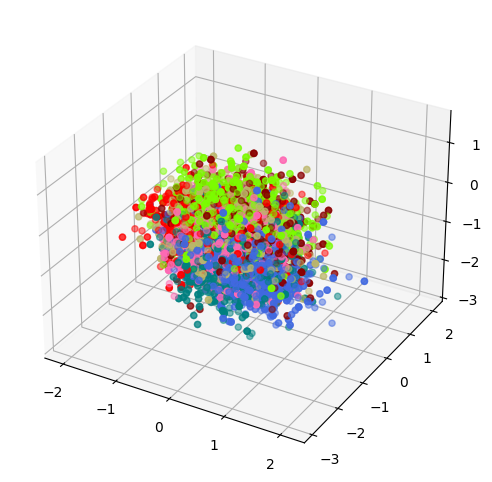

In [96]:
import utils
df_ = pd.concat([pd.DataFrame(X_embedded),data['target']],axis=1)
df_['target'] = df_['target'].astype('int64')
plot_scatter3D(pd.DataFrame(df))